In [73]:
#General stuff
import time
import datetime
import glob
import re
import pandas as pd
from collections import Counter
import progressbar
import jellyfish
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import statsmodels.formula.api as smf
from collections import Counter
from itertools import chain
import numpy

## Pulling in all the files

In [2]:
df = pd.read_csv('data/df_final_harm.csv')

## I want to look for repetitions "sozialrechtliche Abteilungen"
And I'm working with the years, as the whole long string consisting of 15'000 verdicts is just too long. The Kernel dies regularly. Which really isn't much fun.

In [3]:
df_sozrecht = df[df['recht_harm'] == 'Öffentliches Recht']
sozrecht = df_sozrecht[df_sozrecht['Language'] == 'De']['Text-Nummer']

Splitting up the lists.

In [4]:
l = list(sozrecht)
n = 1000
txt_lsts = [l[i:i + n] for i in range(0, len(l), n)]

In [5]:
df_ = pd.DataFrame(columns=['index', 0])
bar = progressbar.ProgressBar()

for txt_lst, i in zip(txt_lsts, bar(range(len(txt_lsts)))):

    long_str = ''
    
    for txt in txt_lst:
    
        file = open('txt_files/' + txt, 'r')
        text = file.read()
        #Making sure the line breaks '/n', 'xa0' and double spaces are removed
        text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', ' ')
        #Removing these automated notifications
        text = text.replace('Wichtiger Hinweis:Diese Website wird in älteren Versionen von Netscape ohne graphische Elemente dargestellt. Die Funktionalität der Website ist aber trotzdem gewährleistet. Wenn Sie diese Website regelmässig benutzen, empfehlen wir Ihnen, auf Ihrem Computer einen aktuellen Browser zu installieren.Zurück zur Einstiegsseite Drucken Grössere Schrift', '')
        text = text.replace('Vorwärts ähnliche Leitentscheide suchenähnliche Urteile ab 2000 suchen Drucken nach oben', '')
        text = text.replace('Bundesgericht Tribunal fédéral Tribunale federale Tribunal federal', '')
        text = text.replace('Navigation Neue Suche Zurück zum Suchresultat Rang: Zurück 180', '')
        text = text.replace('Navigation Neue Suche Zurück zum Suchresultat Rang:1 ähnliche Leitentscheide suchenähnliche Urteile ab 2000 suchen Drucken nach oben', '')
    
        long_str = long_str + text
        
    df_new = pd.DataFrame(pd.Series( long_str[ix:ix+500] for ix in list(range(len(long_str))) ).value_counts()).reset_index()
    df_new = df_new[df_new[0]> 1]
    
    frames = [df_, df_new]
    df_ = pd.concat(frames)
    

 92% (13 of 14) |########################  | Elapsed Time: 0:19:47 ETA: 0:01:44

# Renaming columns
Later, I can just jump to this step, I don't need to repeat the steps above

In [6]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3298911 entries, 0 to 128436
Data columns (total 2 columns):
index    object
0        float64
dtypes: float64(1), object(1)
memory usage: 75.5+ MB


In [7]:
df_.columns = [['String', 'Count']]

# Deleting Duplicates

In [8]:
df_ = df_.drop_duplicates(subset='String', keep='first')

In [9]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3031209 entries, 0 to 128436
Data columns (total 2 columns):
String    object
Count     float64
dtypes: float64(1), object(1)
memory usage: 69.4+ MB


In [10]:
df = df_[df_['Count'] >= 10]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10694 entries, 0 to 5619
Data columns (total 2 columns):
String    10694 non-null object
Count     10694 non-null float64
dtypes: float64(1), object(1)
memory usage: 250.6+ KB


# Matching similar Strings
Using Jellyfish and remodelling the original df, using it to create a new list of string. Because these ones are the ones I don't need to consider anymore.

In [12]:
df_new = pd.DataFrame(columns=['String', 'Count', 'Jaro'])

for count in range(1000):
    
    print(count)
    string_list = list(df['String'])
    value_list = []
    bar = progressbar.ProgressBar()

    for elem, i in zip(string_list, bar(range(len(string_list)))):
    
        value = jellyfish.jaro_distance(string_list[0], elem)
        value_list.append(value)
    
    df['Jaro'] = value_list
    df_unique = df[df['Jaro'] >= .825].head(1)

    frames = [df_new, df_unique]
    df_new = pd.concat(frames)

    df = df[df['Jaro'] <= .825]
    del df['Jaro']

  7% (813 of 10694) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

0


 98% (10559 of 10694) |################### | Elapsed Time: 0:00:01 ETA: 0:00:00/Users/barneyjs/.virtualenvs/master/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
 11% (1207 of 10589) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

1


 11% (1201 of 10539) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

2


  7% (799 of 10509) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

3


 11% (1194 of 10475) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

4


 10% (1056 of 10426) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

5


 11% (1184 of 10392) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

6


 11% (1182 of 10368) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

7


 11% (1176 of 10314) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

8


 10% (1037 of 10237) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

9


 11% (1164 of 10212) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

10


 11% (1163 of 10203) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

11


  8% (904 of 10202) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

12


 11% (1159 of 10167) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

13


  8% (896 of 10105) |#                     | Elapsed Time: 0:00:00 ETA: 0:00:01

14


 11% (1143 of 10029) |##                   | Elapsed Time: 0:00:00 ETA: 0:00:01

15


 11% (1140 of 9998) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

16


  7% (758 of 9975) |#                      | Elapsed Time: 0:00:00 ETA: 0:00:01

17


 12% (1259 of 9946) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

18


 11% (1128 of 9896) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

19


 11% (1127 of 9890) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

20


 11% (1124 of 9860) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

21


 12% (1248 of 9857) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

22


 11% (1117 of 9804) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

23


 11% (1106 of 9703) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

24


 11% (1103 of 9679) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

25


 11% (1103 of 9674) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

26


 11% (1100 of 9648) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

27


 11% (1099 of 9646) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

28


 11% (1095 of 9608) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

29


 11% (1092 of 9579) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

30


  7% (723 of 9511) |#                      | Elapsed Time: 0:00:00 ETA: 0:00:01

31


 11% (1080 of 9478) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

32


 11% (1077 of 9452) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

33


 11% (1072 of 9402) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

34


 11% (1071 of 9397) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

35


 12% (1189 of 9393) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

36


 12% (1189 of 9391) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

37


  8% (829 of 9345) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:02

38


 12% (1180 of 9317) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

39


 11% (1052 of 9226) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

40


  5% (466 of 9199) |#                      | Elapsed Time: 0:00:00 ETA: 0:00:02

41


 10% (929 of 9167) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

42


 10% (925 of 9131) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

43


  8% (805 of 9075) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

44


 11% (1030 of 9036) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

45


 13% (1255 of 9013) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

46


 11% (1027 of 9012) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

47


 11% (1024 of 8982) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

48


 12% (1137 of 8980) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

49


 11% (1023 of 8974) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

50


 11% (1022 of 8969) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

51


 11% (1017 of 8924) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

52


 11% (1017 of 8921) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

53


 11% (1015 of 8903) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

54


 11% (1011 of 8874) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

55


 13% (1235 of 8866) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

56


 13% (1228 of 8818) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

57


 11% (1002 of 8794) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

58


 11% (996 of 8737) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

59


 15% (1318 of 8674) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

60


 13% (1199 of 8609) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

61


 11% (980 of 8602) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

62


 12% (1082 of 8546) |##                    | Elapsed Time: 0:00:00 ETA: 0:00:01

63


 13% (1185 of 8506) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

64


 13% (1170 of 8401) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

65


 15% (1268 of 8345) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

66


 15% (1264 of 8317) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

67


 15% (1264 of 8316) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

68


 13% (1144 of 8210) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

69


 13% (1141 of 8190) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

70


 15% (1237 of 8143) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

71


 15% (1232 of 8105) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

72


 15% (1228 of 8081) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

73


 15% (1219 of 8025) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

74


 15% (1217 of 8006) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

75


 15% (1211 of 7972) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

76


 15% (1211 of 7971) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

77


 15% (1203 of 7917) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

78


 15% (1203 of 7916) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

79


 15% (1196 of 7870) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

80


 15% (1191 of 7835) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

81


 15% (1181 of 7770) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

82


 15% (1174 of 7728) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

83


 15% (1166 of 7676) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

84


 13% (1064 of 7636) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

85


 15% (1154 of 7595) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

86


 15% (1152 of 7582) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

87


 13% (1053 of 7560) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

88


 15% (1142 of 7516) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

89


 15% (1136 of 7475) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

90


 15% (1134 of 7463) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

91


 15% (1131 of 7442) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

92


 15% (1130 of 7433) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

93


 15% (1129 of 7430) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

94


 15% (1129 of 7429) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

95


 12% (941 of 7428) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

96


 11% (847 of 7427) |##                     | Elapsed Time: 0:00:00 ETA: 0:00:01

97


 13% (1034 of 7426) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:01

98


 15% (1123 of 7390) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

99


 15% (1120 of 7369) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

100


 13% (1025 of 7359) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

101


 15% (1116 of 7345) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

102


 15% (1116 of 7343) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

103


 16% (1205 of 7318) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

104


 16% (1193 of 7245) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

105


 15% (1095 of 7205) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

106


 16% (1185 of 7200) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

107


 15% (1086 of 7149) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

108


 13% (993 of 7126) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:01

109


 15% (1077 of 7086) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

110


 15% (1072 of 7051) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

111


 15% (1065 of 7011) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

112


 15% (1065 of 7007) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

113


 16% (1144 of 6949) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

114


 15% (1050 of 6908) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

115


 15% (1040 of 6841) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

116


 15% (1030 of 6780) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

117


 15% (1030 of 6777) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

118


 15% (1024 of 6740) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

119


 15% (1015 of 6680) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

120


 17% (1170 of 6599) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

121


 18% (1244 of 6549) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

122


 16% (1071 of 6508) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

123


 17% (1145 of 6457) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

124


 17% (1138 of 6417) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

125


 17% (1134 of 6394) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

126


 16% (1047 of 6360) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

127


 16% (1041 of 6321) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

128


 16% (1030 of 6258) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

129


 18% (1188 of 6253) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

130


 18% (1182 of 6223) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

131


 18% (1176 of 6191) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

132


 17% (1095 of 6175) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

133


 18% (1163 of 6123) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

134


 18% (1156 of 6087) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

135


 17% (1071 of 6042) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

136


 17% (1066 of 6014) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

137


 19% (1136 of 5978) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

138


 18% (1131 of 5955) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

139


 18% (1128 of 5938) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

140


 18% (1127 of 5934) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

141


 18% (1127 of 5933) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

142


 18% (1125 of 5925) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

143


 18% (1124 of 5917) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

144


 19% (1124 of 5915) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

145


 17% (1048 of 5913) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

146


 18% (1122 of 5907) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

147


 18% (1122 of 5906) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

148


 17% (1047 of 5904) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

149


 17% (1032 of 5820) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

150


 17% (1032 of 5818) |###                   | Elapsed Time: 0:00:00 ETA: 0:00:00

151


 18% (1094 of 5761) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

152


 18% (1083 of 5703) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

153


 19% (1080 of 5683) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

154


 20% (1151 of 5679) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

155


 18% (1070 of 5634) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

156


 17% (990 of 5581) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

157


 18% (1055 of 5554) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

158


 18% (1053 of 5545) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

159


 20% (1123 of 5544) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

160


 18% (1048 of 5516) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

161


 18% (1045 of 5502) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

162


 20% (1095 of 5402) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

163


 20% (1078 of 5321) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

164


 21% (1137 of 5280) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

165


 22% (1193 of 5234) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

166


 22% (1185 of 5200) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

167


 22% (1175 of 5153) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

168


 20% (1029 of 5078) |####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

169


 16% (827 of 5021) |###                    | Elapsed Time: 0:00:00 ETA: 0:00:00

170


 17% (884 of 4985) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

171


 22% (1127 of 4945) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

172


 22% (1110 of 4868) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

173


 22% (1099 of 4820) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

174


 22% (1088 of 4774) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

175


 22% (1078 of 4730) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

176


 22% (1068 of 4683) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

177


 22% (1056 of 4634) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

178


 22% (1041 of 4565) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

179


 17% (802 of 4523) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

180


 21% (967 of 4493) |####                   | Elapsed Time: 0:00:00 ETA: 0:00:00

181


 25% (1129 of 4457) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

182


 25% (1110 of 4383) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

183


 26% (1155 of 4345) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

184


 25% (1099 of 4338) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

185


 26% (1144 of 4301) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

186


 24% (1032 of 4287) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

187


 26% (1137 of 4274) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

188


 26% (1131 of 4253) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

189


 26% (1129 of 4245) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

190


 26% (1122 of 4219) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

191


 26% (1118 of 4203) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

192


 26% (1116 of 4198) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

193


 25% (1063 of 4197) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

194


 24% (1001 of 4160) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

195


 26% (1087 of 4089) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

196


 26% (1073 of 4035) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

197


 25% (1012 of 3996) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

198


 26% (1044 of 3926) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

199


 26% (1021 of 3839) |#####                 | Elapsed Time: 0:00:00 ETA: 0:00:00

200


 22% (863 of 3785) |#####                  | Elapsed Time: 0:00:00 ETA: 0:00:00

201


 26% (984 of 3701) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

202


 29% (1056 of 3626) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

203


 26% (950 of 3572) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

204


 26% (931 of 3500) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

205


 30% (1048 of 3449) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

206


 30% (1036 of 3409) |######                | Elapsed Time: 0:00:00 ETA: 0:00:00

207


 29% (985 of 3381) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

208


 29% (958 of 3289) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

209


 26% (865 of 3252) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

210


 26% (840 of 3158) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

211


 29% (902 of 3097) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

212


 31% (971 of 3066) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

213


 32% (1000 of 3037) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

214


 35% (1046 of 2949) |#######               | Elapsed Time: 0:00:00 ETA: 0:00:00

215


 34% (994 of 2906) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

216


 36% (1041 of 2835) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

217


 35% (991 of 2795) |########               | Elapsed Time: 0:00:00 ETA: 0:00:00

218


 36% (1006 of 2739) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

219


 34% (928 of 2715) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

220


 31% (840 of 2653) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

221


 26% (695 of 2614) |######                 | Elapsed Time: 0:00:00 ETA: 0:00:00

222


 37% (987 of 2598) |########               | Elapsed Time: 0:00:00 ETA: 0:00:00

223


 39% (1007 of 2566) |########              | Elapsed Time: 0:00:00 ETA: 0:00:00

224


 35% (882 of 2488) |########               | Elapsed Time: 0:00:00 ETA: 0:00:00

225


 40% (986 of 2433) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

226


 32% (797 of 2420) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

227


 41% (1002 of 2397) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

228


 41% (988 of 2364) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

229


 44% (1035 of 2336) |#########             | Elapsed Time: 0:00:00 ETA: 0:00:00

230


 38% (876 of 2305) |########               | Elapsed Time: 0:00:00 ETA: 0:00:00

231


 36% (810 of 2205) |########               | Elapsed Time: 0:00:00 ETA: 0:00:00

232


 46% (1020 of 2177) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

233


 48% (1017 of 2113) |##########            | Elapsed Time: 0:00:00 ETA: 0:00:00

234


 51% (1058 of 2038) |###########           | Elapsed Time: 0:00:00 ETA: 0:00:00

235


 50% (1014 of 2001) |###########           | Elapsed Time: 0:00:00 ETA: 0:00:00

236


 53% (1057 of 1988) |###########           | Elapsed Time: 0:00:00 ETA: 0:00:00

237


 51% (986 of 1898) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

238


 50% (941 of 1857) |###########            | Elapsed Time: 0:00:00 ETA: 0:00:00

239


 40% (742 of 1831) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

240


 53% (949 of 1784) |############           | Elapsed Time: 0:00:00 ETA: 0:00:00

241


 56% (1002 of 1758) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

242


 58% (1006 of 1726) |############          | Elapsed Time: 0:00:00 ETA: 0:00:00

243


 59% (1005 of 1688) |#############         | Elapsed Time: 0:00:00 ETA: 0:00:00

244


 58% (939 of 1611) |#############          | Elapsed Time: 0:00:00 ETA: 0:00:00

245


 62% (974 of 1569) |##############         | Elapsed Time: 0:00:00 ETA: 0:00:00

246


 60% (936 of 1539) |#############          | Elapsed Time: 0:00:00 ETA: 0:00:00

247


 62% (948 of 1527) |##############         | Elapsed Time: 0:00:00 ETA: 0:00:00

248


 58% (888 of 1524) |#############          | Elapsed Time: 0:00:00 ETA: 0:00:00

249


 62% (942 of 1518) |##############         | Elapsed Time: 0:00:00 ETA: 0:00:00

250


 41% (622 of 1489) |#########              | Elapsed Time: 0:00:00 ETA: 0:00:00

251


 31% (459 of 1450) |#######                | Elapsed Time: 0:00:00 ETA: 0:00:00

252


 54% (785 of 1441) |############           | Elapsed Time: 0:00:00 ETA: 0:00:00

253


 65% (926 of 1406) |###############        | Elapsed Time: 0:00:00 ETA: 0:00:00

254


 56% (788 of 1383) |#############          | Elapsed Time: 0:00:00 ETA: 0:00:00

255


 62% (843 of 1358) |##############         | Elapsed Time: 0:00:00 ETA: 0:00:00

256


 79% (1060 of 1328) |#################     | Elapsed Time: 0:00:00 ETA: 0:00:00

257


 74% (970 of 1298) |#################      | Elapsed Time: 0:00:00 ETA: 0:00:00

258


 74% (957 of 1281) |#################      | Elapsed Time: 0:00:00 ETA: 0:00:00

259


 74% (945 of 1265) |#################      | Elapsed Time: 0:00:00 ETA: 0:00:00

260


 78% (971 of 1237) |##################     | Elapsed Time: 0:00:00 ETA: 0:00:00

261


 78% (953 of 1214) |##################     | Elapsed Time: 0:00:00 ETA: 0:00:00

262


 75% (921 of 1212) |#################      | Elapsed Time: 0:00:00 ETA: 0:00:00

263


 79% (963 of 1207) |##################     | Elapsed Time: 0:00:00 ETA: 0:00:00

264


 77% (923 of 1195) |#################      | Elapsed Time: 0:00:00 ETA: 0:00:00

265


 79% (949 of 1190) |##################     | Elapsed Time: 0:00:00 ETA: 0:00:00

266


 77% (918 of 1188) |#################      | Elapsed Time: 0:00:00 ETA: 0:00:00

267


 60% (721 of 1186) |#############          | Elapsed Time: 0:00:00 ETA: 0:00:00

268


 69% (823 of 1182) |################       | Elapsed Time: 0:00:00 ETA: 0:00:00

269


 72% (850 of 1178) |################       | Elapsed Time: 0:00:00 ETA: 0:00:00

270


 84% (997 of 1175) |###################    | Elapsed Time: 0:00:00 ETA: 0:00:00

271


 77% (906 of 1173) |#################      | Elapsed Time: 0:00:00 ETA: 0:00:00

272


 82% (963 of 1170) |##################     | Elapsed Time: 0:00:00 ETA: 0:00:00

273


 84% (991 of 1168) |###################    | Elapsed Time: 0:00:00 ETA: 0:00:00

274


 76% (887 of 1167) |#################      | Elapsed Time: 0:00:00 ETA: 0:00:00

275


 93% (1093 of 1166) |####################  | Elapsed Time: 0:00:00 ETA: 0:00:00

276


 86% (956 of 1110) |###################    | Elapsed Time: 0:00:00 ETA: 0:00:00

277


 67% (692 of 1030) |###############        | Elapsed Time: 0:00:00 ETA: 0:00:00

278


N/A% (0 of 906) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

279
280


N/A% (0 of 803) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

281
282


N/A% (0 of 734) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

283
284


N/A% (0 of 665) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

285
286


 55% (335 of 600) |############           | Elapsed Time: 0:00:00 ETA:  0:00:00

287
288


 64% (368 of 569) |##############         | Elapsed Time: 0:00:00 ETA:  0:00:00

289
290


 57% (321 of 562) |#############          | Elapsed Time: 0:00:00 ETA:  0:00:00

291
292


 53% (297 of 557) |############           | Elapsed Time: 0:00:00 ETA:  0:00:00

293
294


N/A% (0 of 525) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

295
296


 87% (366 of 418) |####################   | Elapsed Time: 0:00:00 ETA:  0:00:00

297
298


 86% (281 of 326) |###################    | Elapsed Time: 0:00:00 ETA:  0:00:00

299
300


N/A% (0 of 236) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

301
302


N/A% (0 of 201) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

303
304
305


N/A% (0 of 193) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

306
307


N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

308
309
310


N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560


# Cleaning the New DF and Creating a String

In [13]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314 entries, 0 to 5375
Data columns (total 3 columns):
String    314 non-null object
Count     314 non-null float64
Jaro      314 non-null float64
dtypes: float64(2), object(1)
memory usage: 9.8+ KB


In [14]:
del df_new['Count']

In [15]:
del df_new['Jaro']

In [16]:
len(list(df_new['String']))

314

In [17]:
string_list = list(df_new['String'])

# Iterating through all the files

Functions to pull out relevant information

In [18]:
REGEXES_SCHREIBER = [
    r'[gG]reffier\s*:*\s*\w*\.*\s*\w*',
    r'[Gg]reffière\s*:*\s*\w*\.*\s*\w*',
    r'[gG]erichtsschreiberi*n*\s*:* \w*\.*\s*\w*',
    r'[Cc]ancelliere*n*\s*:* \w*\.*\s*\w*']

In [19]:
def gerichtsschreiber(doc):
    try:
        text = next(chain.from_iterable(re.finditer(r, doc) for r in REGEXES_SCHREIBER), None)
        return text.group()
    except:
        None

In [20]:
def extracting_date(doc):
    Datum = re.findall(r"[0-9]+\.[0-9]+\.20[0-9]+", doc)
    try:
        return Datum[0]
    except:
        pass

In [21]:
def extracting_akten_nummer(doc):
    an = re.findall(r"[0-9]*[A-Z][.]*[_]*[ ]*[0-9]+/[0-9]+", doc)
    try:
        an = an[0]
        an = an.replace('_', ' ')
        return an
    except:
        pass

In [22]:
l = list(sozrecht)

In [23]:
txt_elems = []
bar = progressbar.ProgressBar()

for text_file, i in zip(l, bar((range(len(l))))):
    
    file = open('txt_files/' + text_file, 'r')
    text = file.read()
    file.close()
    
    #Special formatting
    text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', '')
    text = text.replace('  ', ' ')
    
    Datum = extracting_date(text)
    Aktennummer = extracting_akten_nummer(text)
    Gerichtsschreiber = gerichtsschreiber(text)
    
    
    if string_list[0] in text:
        boolean = 1
    else:
        boolean = 0
    
    mini_dict = {'Text Nummer': text_file,
                 'Datum': Datum,
                 string_list[0][:20]: boolean,
                 'Aktennummer': Aktennummer,
                 'Gerichtsschreiber': Gerichtsschreiber}
    
    txt_elems.append(mini_dict)

 99% (13806 of 13821) |################### | Elapsed Time: 0:00:22 ETA: 0:00:00

In [24]:
df_bools = pd.DataFrame(txt_elems)

# Repeat what I did above, now attaching the lists to df_bools

In [25]:
bar = progressbar.ProgressBar()

for string, i in zip(string_list, bar(range(len(string_list)))):
    
    bool_list = []
    
    for text_file in l:
    
        file = open('txt_files/' + text_file, 'r')
        text = file.read()
        file.close()
    
        #Special formatting
        text = text.replace('\n', ' ').replace('\xa0', '').replace('  ', '')
        text = text.replace('  ', ' ')
    
        if string in text:
            boolean = 1
        else:
            boolean = 0
        
        bool_list.append(boolean)
    
    df_bools[string[:20]] = bool_list

 99% (313 of 314) |####################### | Elapsed Time: 0:11:11 ETA: 0:00:02

In [26]:
df_bools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13821 entries, 0 to 13820
Columns: 316 entries, Aktennummer to en und deren Begründ
dtypes: int64(312), object(4)
memory usage: 33.3+ MB


In [27]:
df_bools.to_csv('bools_text_snippets_de_ör.csv')

In [28]:
df_bools = pd.read_csv('bools_text_snippets_de_ör.csv')

In [29]:
del df_bools['Unnamed: 0']

# Making Total Column

In [30]:
df_bools['TOTAL'] = df_bools.sum(axis=1, numeric_only=True)

In [31]:
df_bools['TOTAL'].describe()

count    13821.000000
mean         0.379423
std          3.871304
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        115.000000
Name: TOTAL, dtype: float64

# Dates

In [32]:
df_bools['Datetime'] = pd.to_datetime(df_bools['Datum'], format="%d.%m.%Y")
df_bools.index = df_bools['Datetime']

# Plotting and Linear Regression

In [33]:
df_counts_pyear = pd.DataFrame(df_bools.resample('A')['TOTAL'].sum()).reset_index()

In [34]:
def change(elem):
    elem = str(elem)
    elem = int(elem.replace('-12-31 00:00:00', ''))
    return elem

In [35]:
df_counts_pyear

,Datetime,TOTAL
0,2007-12-31,8
1,2008-12-31,1896
2,2009-12-31,130
3,2010-12-31,40
4,2011-12-31,181
5,2012-12-31,248
6,2013-12-31,541
7,2014-12-31,549
8,2015-12-31,663
9,2016-12-31,579


In [36]:
df_counts_pyear['Years'] = df_counts_pyear['Datetime'].apply(change)

In [37]:
lm = smf.ols(formula="TOTAL~Years",data=df_counts_pyear).fit()

In [38]:
lm.params

Intercept    5707.927273
Years          -2.600000
dtype: float64

In [39]:
intercept, slope = lm.params

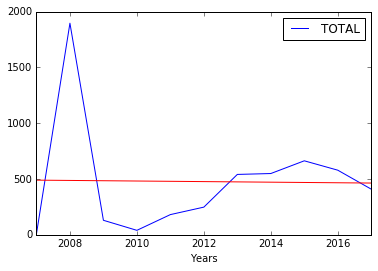

In [40]:
df_counts_pyear.plot(x="Years",y="TOTAL")
plt.plot(df_counts_pyear["Years"],slope*df_counts_pyear["Years"]+intercept,"-",color="red") 

# Without 2017

In [41]:
df_2007_2016 = df_counts_pyear[df_counts_pyear['Years'] != 2017]

In [42]:
lm = smf.ols(formula="TOTAL~Years",data=df_2007_2016).fit()

In [43]:
lm.params

Intercept   -1625.527273
Years           1.048485
dtype: float64

In [44]:
intercept, slope = lm.params

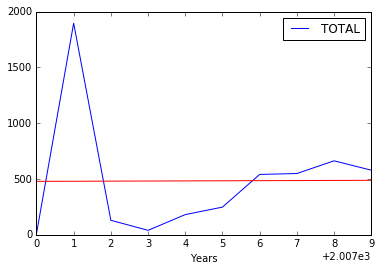

In [45]:
df_2007_2016.plot(x="Years",y="TOTAL")
plt.plot(df_2007_2016["Years"],slope*df_2007_2016["Years"]+intercept,"-",color="red")

In [46]:
df_2007_2016.to_csv('2007_2016_ör_de.csv')

# Harmonising at Gerichtsschreiber

In [47]:
def harm(elem):
    try:
        elem = elem.replace('R.', 'R')
        elem = elem.split('.')[0].replace('Gerichtsschreiber ', '').replace('Gerichtsschreiberin ', '')
        return elem
    except:
        return elem

In [48]:
df_bools['Schreiberharm'] = df_bools['Gerichtsschreiber'].apply(harm)

In [49]:
df_bools['Schreiberharm'].value_counts().head()

Feller      1812
Pfäffli     1395
Bopp         964
Hugi Yar     738
Härri        537
Name: Schreiberharm, dtype: int64

# Merging with large file to sort out Abgeschrieben/Nichteingetreten

In [50]:
df = pd.read_csv('data/df_final_harm.csv')
df = df[['Aktennummer', 'Entscheid_harm']].copy()
df_ = df_bools.merge(df, left_on='Aktennummer', right_on='Aktennummer')
df_ = df_[df_['Entscheid_harm'] != 'Nicht eingetreten']

# Working out, total by Clerk

In [51]:
df_totalelems = pd.DataFrame(df_.groupby('Schreiberharm')['TOTAL'].sum().sort_values(ascending=False))

# Working out number of appeals, we counted their involvement in

In [52]:
df = pd.read_csv('data/df_final_harm.csv')
df = df[df['Entscheid_harm'] != 'Nicht eingetreten']
df_sozrecht = df[df['recht_harm'] == 'Öffentliches Recht']
df_sozrecht = df_sozrecht[df_sozrecht['Language'] == 'De']

In [53]:
df_totalappeals = pd.DataFrame(df_sozrecht['Schreiber_harm'].value_counts())

# Merging total Elem Count with total Appeals by Clerk

In [54]:
df_final = df_totalelems.merge(df_totalappeals, how='left', left_index=True, right_index=True)

In [55]:
df_final.columns = [['ELEM 500 COUNT', 'TOTAL APPEALS']]
df_final['Elem pCase'] = round(df_final['ELEM 500 COUNT'] / df_final['TOTAL APPEALS'], 1)

In [56]:
df_final.sort_values(by='Elem pCase', ascending=False).head(30)

,ELEM 500 COUNT,TOTAL APPEALS,Elem pCase
Schreiberharm,,,
Scherrer,1887,105.0,18.0
Hugi,4,1.0,4.0
Mayhall,231,141.0,1.6
Genner,210,162.0,1.3
Egli,75,77.0,1.0
Kocher,134,217.0,0.6
Pfäffli,116,185.0,0.6
Haag,72,202.0,0.4
Gerber,165,394.0,0.4


# Gutheissungsquote nach Gerichtsschreiber

In [57]:
df_gut = pd.read_csv('data/schreiber_percent.csv')

In [58]:
df_gut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
Unnamed: 0             250 non-null int64
Abgewiesen %           250 non-null float64
Gutgeheissen %         250 non-null float64
Nicht eingetreten %    250 non-null float64
Schreiber              250 non-null object
Total                  250 non-null int64
dtypes: float64(3), int64(2), object(1)
memory usage: 11.8+ KB


In [59]:
df_gut = df_gut[['Schreiber', 'Gutgeheissen %']].copy()
def remove(elem):
    elem = elem.replace('.', '')
    return elem
df_gut['Schreiber'] = df_gut['Schreiber'].apply(remove)
df_gut.index = df_gut['Schreiber']
del df_gut['Schreiber']

# Merge with final df

In [60]:
df_final = df_final.merge(df_gut, how='left', left_index=True, right_index=True)

In [61]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, Scherrer to Berger Götz
Data columns (total 4 columns):
ELEM 500 COUNT    72 non-null int64
TOTAL APPEALS     64 non-null float64
Elem pCase        64 non-null float64
Gutgeheissen %    61 non-null float64
dtypes: float64(3), int64(1)
memory usage: 2.8+ KB


In [62]:
df_final.sort_values(by='Elem pCase', ascending=False).head(50)
df_final = df_final[df_final['TOTAL APPEALS'] > 50]

In [63]:
#df_final.drop('Monn', inplace=True)
#df_final.drop('Arquint Hill', inplace=True)

In [64]:
df_final.columns = [['ELEM 500 COUNT', 'TOTAL APPEALS', 'ElempCase', 'Gutgeheissen']]

# Is there a correlation between amout of copy pasted elements and the percentage of successful appeals?

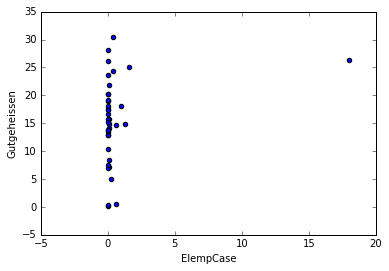

In [65]:
df_final.plot(kind='scatter', x='ElempCase', y='Gutgeheissen')

In [66]:
lm = smf.ols(formula="ElempCase~Gutgeheissen",data=df_final).fit()

In [67]:
intercept, slope = lm.params

In [68]:
lm.params

Intercept      -0.903929
Gutgeheissen    0.100050
dtype: float64

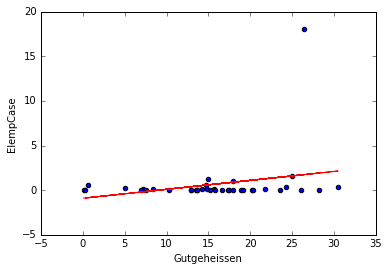

In [69]:
df_final.plot(kind='scatter', x="Gutgeheissen",y="ElempCase")
plt.plot(df_final["Gutgeheissen"],slope*df_final["Gutgeheissen"]+intercept,"-",color="red") 

In [70]:
df_final

,ELEM 500 COUNT,TOTAL APPEALS,ElempCase,Gutgeheissen
Schreiberharm,,,,
Scherrer,1887,105.0,18.0,26.4
Mayhall,231,141.0,1.6,25.0
Genner,210,162.0,1.3,14.9
Gerber,165,394.0,0.4,30.5
Kocher,134,217.0,0.6,14.7
Pfäffli,116,185.0,0.6,0.6
Egli,75,77.0,1.0,18.0
Haag,72,202.0,0.4,24.3
Hugi Yar,55,559.0,0.1,8.4


In [71]:
df_final.to_csv('ör_500_de.csv')

In [72]:
# Merge with french Data